# Min-Conflicts N-Queens — Hyperparameter Scaling & Optimization

This notebook analyzes benchmark results from one or more CSVs produced by:

```bash
python -m benchmarks.bench_minconflicts
```

Each row corresponds to a single run with fixed:
- n
- candidate_selector ∈ {k_sample, nbhd}
- candidate_count
- structured_init ∈ {0,1}
- seed

Goals:

1. Aggregate across seeds to get mean + variance per base config.

2. Visualize how steps and runtime scale with board size n.

3. Visualize how hyperparameters affect performance at fixed n, e.g. varying candidate_count.

4. Fit simple polynomial models (deg 1 or 2) of steps_mean(n) and time_mean(n) for each config.

5. Use those models to:
  - pick the best hyperparameters for a target n (among the tested grid),
  - estimate the maximum n we can solve under a time budget.



## Notebook Setup & Utilities

This cell defines all helper functions:

- Loading and merging multiple CSVs.
- Computing derived metrics (steps_per_n, etc.).
- Aggregating per base config (across seeds).
- Fitting polynomial models in `n` with MSE + R².
- Plotting:
  - steps/time vs n with fitted curves,
  - steps/time vs `candidate_count` at fixed n.
- Recommending configs and estimating max `n` for time limits.
- Evaluating grid-search health.

In [ ]:
# Cell 1 — Utility function definitions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict, List
from IPython.display import display


# -------------------------------
# Loading & preprocessing
# -------------------------------

def load_results_multifile(csv_paths: List[str]) -> pd.DataFrame:
    """
    Load and merge multiple benchmark CSVs into a single DataFrame.

    - Adds a 'source_file' column indicating origin.
    - Drops exact duplicate runs based on key identifiers:
        (n, candidate_selector, candidate_count, structured_init, seed)
      so merging overlapping configs is robust.
    """
    dfs: List[pd.DataFrame] = []
    for path in csv_paths:
        df = pd.read_csv(path)
        df["source_file"] = path
        dfs.append(df)

    if not dfs:
        return pd.DataFrame()

    df_all = pd.concat(dfs, ignore_index=True)

    # Define run-identity keys (one row per run)
    key_cols = [
        "n",
        "candidate_selector",
        "candidate_count",
        "structured_init",
        "seed",
    ]
    key_cols = [c for c in key_cols if c in df_all.columns]
    if key_cols:
        df_all = df_all.drop_duplicates(subset=key_cols, keep="last")

    return df_all


def add_derived_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["steps_per_n"] = df["steps"] / df["n"]
    df["time_per_n"] = df["total_time_sec"] / df["n"]
    df["time_per_step"] = np.where(
        df["steps"] > 0, df["total_time_sec"] / df["steps"], np.nan
    )
    df["config_label"] = (
        "n=" + df["n"].astype(str)
        + ", sel=" + df["candidate_selector"]
        + ", C=" + df["candidate_count"].astype(str)
        + ", S=" + df["structured_init"].astype(str)
    )
    return df


def summarize_unique_values(df: pd.DataFrame) -> None:
    print("Unique n:", sorted(df["n"].unique()))
    print("Unique candidate_selectors:", df["candidate_selector"].unique().tolist())
    print("Unique candidate_counts:", sorted(df["candidate_count"].unique()))
    print("Unique structured_init:", sorted(df["structured_init"].unique()))
    if "seed" in df.columns:
        print("Unique seeds:", sorted(df["seed"].unique()))
    if "source_file" in df.columns:
        print("Source files:", df["source_file"].unique().tolist())
    print("Runs shape:", df.shape)


# -------------------------------
# Aggregation across seeds
# -------------------------------

def aggregate_by_config(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate multiple runs per base hyperparameter config:
      group by (n, candidate_selector, candidate_count, structured_init)
      and compute mean/std for key metrics.

    This is where variance across different seeds is captured.
    """
    group_cols = ["n", "candidate_selector", "candidate_count", "structured_init"]
    g = df.groupby(group_cols, dropna=False)
    agg = g.agg(
        runs_observed=("steps", "size"),
        solved_mean=("solved", "mean"),
        steps_mean=("steps", "mean"),
        steps_std=("steps", "std"),
        time_mean=("total_time_sec", "mean"),
        time_std=("total_time_sec", "std"),
        steps_per_n_mean=("steps_per_n", "mean"),
        steps_per_n_std=("steps_per_n", "std"),
        time_per_n_mean=("time_per_n", "mean"),
        time_per_n_std=("time_per_n", "std"),
        time_per_step_mean=("time_per_step", "mean"),
        time_per_step_std=("time_per_step", "std"),
        final_conflicts_mean=("final_conflicts", "mean"),
        final_conflicts_std=("final_conflicts", "std"),
    ).reset_index()

    # Coefficient of variation (noise level)
    for base in ["steps", "time", "steps_per_n", "time_per_n"]:
        mean_col = f"{base}_mean"
        std_col = f"{base}_std"
        cv_col = f"{base}_cv"
        if mean_col in agg.columns and std_col in agg.columns:
            agg[cv_col] = agg[std_col] / agg[mean_col]

    return agg


# -------------------------------
# Polynomial models in n
# -------------------------------

def fit_polynomial_models(
    agg: pd.DataFrame,
    metric_col: str,
    max_degree: int = 2,
    min_points: int = 3,
) -> pd.DataFrame:
    """
    For each base hyperparam combo (selector, candidate_count, structured_init),
    fit a polynomial in n for the chosen metric (e.g., steps_mean or time_mean).

    - Tries degree 1 and 2 (up to max_degree).
    - Picks the degree with lowest MSE.
    - Computes R^2 for the chosen fit.
    - Returns one row per hyperparam combo with:
        chosen_degree, coeffs, mse, r2.
    """
    combos = agg[["candidate_selector", "candidate_count", "structured_init"]].drop_duplicates()
    records: List[Dict[str, Any]] = []

    for _, combo_row in combos.iterrows():
        cand_sel = combo_row["candidate_selector"]
        cand_count = combo_row["candidate_count"]
        struct = combo_row["structured_init"]

        sub = agg[
            (agg["candidate_selector"] == cand_sel)
            & (agg["candidate_count"] == cand_count)
            & (agg["structured_init"] == struct)
        ].sort_values("n")

        if len(sub) < min_points:
            continue

        n_vals = sub["n"].to_numpy(dtype=float)
        y_vals = sub[metric_col].to_numpy(dtype=float)

        best_deg = None
        best_coeffs = None
        best_mse = None
        best_r2 = None

        for deg in range(1, max_degree + 1):
            if len(n_vals) <= deg:
                continue
            coeffs = np.polyfit(n_vals, y_vals, deg=deg)
            y_pred = np.polyval(coeffs, n_vals)

            mse = float(np.mean((y_vals - y_pred) ** 2))

            y_mean = float(np.mean(y_vals))
            sst = float(np.sum((y_vals - y_mean) ** 2))
            sse = float(np.sum((y_vals - y_pred) ** 2))
            r2 = 1.0 - sse / sst if sst > 0 else 1.0

            if best_mse is None or mse < best_mse:
                best_mse = mse
                best_deg = deg
                best_coeffs = coeffs
                best_r2 = r2

        if best_deg is None or best_coeffs is None:
            continue

        records.append(
            {
                "candidate_selector": cand_sel,
                "candidate_count": cand_count,
                "structured_init": struct,
                "metric_col": metric_col,
                "chosen_degree": best_deg,
                "coeffs": best_coeffs,
                "mse": best_mse,
                "r2": best_r2,
            }
        )

    return pd.DataFrame(records)


def poly_to_equation_str(coeffs: np.ndarray, var_name: str = "n", y_name: str = "y") -> str:
    """Convert polynomial coefficients into a human-readable equation string."""
    deg = len(coeffs) - 1
    terms = []
    for i, c in enumerate(coeffs):
        power = deg - i
        if power == 0:
            term = f"{c:.3e}"
        elif power == 1:
            term = f"{c:.3e}*{var_name}"
        else:
            term = f"{c:.3e}*{var_name}^{power}"
        terms.append(term)
    rhs = " + ".join(terms)
    return f"{y_name} ≈ {rhs}"


def build_prediction_table(
    model_df: pd.DataFrame,
    n_target: float,
) -> pd.DataFrame:
    """
    Given a model_df from fit_polynomial_models and a target n,
    compute predicted metric value at that n for each hyperparam combo.
    """
    rows = []
    for _, row in model_df.iterrows():
        coeffs = np.array(row["coeffs"], dtype=float)
        y_pred = float(np.polyval(coeffs, n_target))
        rows.append(
            {
                "candidate_selector": row["candidate_selector"],
                "candidate_count": row["candidate_count"],
                "structured_init": row["structured_init"],
                "metric_col": row["metric_col"],
                "chosen_degree": int(row["chosen_degree"]),
                "coeffs": coeffs,
                "mse": float(row["mse"]),
                "r2": float(row["r2"]),
                "n_target": float(n_target),
                "pred_metric": y_pred,
            }
        )
    return pd.DataFrame(rows)


def recommend_configs(
    pred_table: pd.DataFrame,
    metric_col: str,
    n_target: float,
    top_k: int = 10,
) -> pd.DataFrame:
    """
    Among the discrete hyperparameter combos that were *actually tested*,
    pick the top_k with smallest predicted metric at n_target.
    """
    sub = pred_table[
        (pred_table["metric_col"] == metric_col)
        & (pred_table["n_target"] == float(n_target))
    ].copy()
    sub = sub.sort_values("pred_metric", ascending=True)
    return sub.head(top_k)


def compute_max_n_for_metric_limit(
    model_df: pd.DataFrame,
    metric_col: str,
    metric_limit: float,
) -> pd.DataFrame:
    """
    For each hyperparam combo, estimate the largest n such that
        metric(n) <= metric_limit
    according to the fitted polynomial model.

    Returns one row per combo with 'max_n'.
    """
    rows = []
    sub_models = model_df[model_df["metric_col"] == metric_col]

    for _, row in sub_models.iterrows():
        coeffs = np.array(row["coeffs"], dtype=float)
        deg = int(row["chosen_degree"])

        adj_coeffs = coeffs.copy()
        adj_coeffs[-1] = adj_coeffs[-1] - metric_limit

        roots = np.roots(adj_coeffs)
        real_roots = roots[np.isclose(roots.imag, 0.0, atol=1e-6)].real
        positive_roots = real_roots[real_roots > 0]

        max_n = float(positive_roots.max()) if len(positive_roots) > 0 else np.nan

        rows.append(
            {
                "candidate_selector": row["candidate_selector"],
                "candidate_count": row["candidate_count"],
                "structured_init": row["structured_init"],
                "metric_col": metric_col,
                "chosen_degree": deg,
                "coeffs": coeffs,
                "mse": float(row["mse"]),
                "r2": float(row["r2"]),
                "metric_limit": float(metric_limit),
                "max_n": max_n,
            }
        )

    return pd.DataFrame(rows)


# -------------------------------
# Plotting helpers
# -------------------------------

def plot_metric_vs_n_with_fit(
    agg: pd.DataFrame,
    model_df: pd.DataFrame,
    metric_col: str,
    candidate_selector: str,
    candidate_count: int,
    structured_init: int,
    y_label: str,
    title: str,
    ax=None,
) -> None:
    """
    Existing style: metric vs n for one hyperparam combo, with error bars and fitted polynomial.
    """
    if ax is None:
        fig, ax = plt.subplots()

    mask = (
        (agg["candidate_selector"] == candidate_selector)
        & (agg["candidate_count"] == candidate_count)
        & (agg["structured_init"] == structured_init)
    )
    sub = agg[mask].sort_values("n")
    if sub.empty:
        ax.set_title("No data for requested configuration")
        return

    x = sub["n"].to_numpy(dtype=float)
    y = sub[metric_col].to_numpy(dtype=float)

    if metric_col.endswith("_mean"):
        base_name = metric_col.replace("_mean", "")
        std_col = f"{base_name}_std"
        yerr = sub[std_col].to_numpy(dtype=float)
    else:
        yerr = None

    model_row = model_df[
        (model_df["candidate_selector"] == candidate_selector)
        & (model_df["candidate_count"] == candidate_count)
        & (model_df["structured_init"] == structured_init)
        & (model_df["metric_col"] == metric_col)
    ]
    coeffs = None
    degree = None
    r2 = None
    equation_str = ""
    if not model_row.empty:
        coeffs = np.array(model_row.iloc[0]["coeffs"], dtype=float)
        degree = int(model_row.iloc[0]["chosen_degree"])
        r2 = float(model_row.iloc[0]["r2"])
        equation_str = poly_to_equation_str(coeffs, var_name="n", y_name=metric_col)

    ax.errorbar(
        x,
        y,
        yerr=yerr,
        fmt="o",
        label="data (mean ± std)",
        capsize=3,
    )

    if coeffs is not None:
        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = np.polyval(coeffs, x_fit)
        fit_label = f"fit (deg={degree}, R²={r2:.3f}): {equation_str}"
        ax.plot(x_fit, y_fit, label=fit_label)

    ax.set_xlabel("n (board size)")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(fontsize=7)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)


def plot_metric_vs_candidate_count_for_n(
    agg: pd.DataFrame,
    n_value: int,
    metric_col: str,
    y_label: str,
    title_prefix: str,
) -> None:
    """
    New style: for a fixed n, show metric vs candidate_count.

    - One figure per n.
    - Each line corresponds to a (candidate_selector, structured_init) combo.
    - Error bars show std across seeds.
    """
    sub_n = agg[agg["n"] == n_value].copy()
    if sub_n.empty:
        print(f"[plot] No data for n={n_value}")
        return

    if metric_col.endswith("_mean"):
        base_name = metric_col.replace("_mean", "")
        std_col = f"{base_name}_std"
    else:
        std_col = None

    fig, ax = plt.subplots(figsize=(7, 4))

    for sel in sorted(sub_n["candidate_selector"].unique()):
        for s in sorted(sub_n["structured_init"].unique()):
            mask = (
                (sub_n["candidate_selector"] == sel)
                & (sub_n["structured_init"] == s)
            )
            sub = sub_n[mask].sort_values("candidate_count")
            if sub.empty:
                continue
            x = sub["candidate_count"].to_numpy(dtype=float)
            y = sub[metric_col].to_numpy(dtype=float)
            yerr = sub[std_col].to_numpy(dtype=float) if std_col is not None else None
            label = f"{sel}, S={s}"
            ax.errorbar(
                x,
                y,
                yerr=yerr,
                marker="o",
                linestyle="-",
                capsize=3,
                label=label,
            )

    ax.set_xlabel("candidate_count (C)")
    ax.set_ylabel(y_label)
    ax.set_title(f"{title_prefix} @ n={n_value}")
    ax.set_xscale("log")  # C is typically 32/128/512/1024; log scale is useful
    ax.legend(fontsize=7)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()


## Load Results, Aggregate Across Seeds, and Fit Models

This cell:

1. Loads one or more CSV files.
2. Adds derived columns.
3. Shows a quick summary of what’s in the merged dataset.
4. Filters to solved runs for scaling / modeling.
5. Aggregates **across seeds** for each base config.
6. Fits polynomial models `steps_mean(n)` and `time_mean(n)` for each config.


In [ ]:
# Cell 2a — load data, aggregate, fit models

csv_paths = [
    "../benchmarks/results/minconflicts_grid.csv",
    # add more files here as you collect additional grids
]

df_raw = load_results_multifile(csv_paths)
df = add_derived_columns(df_raw)

print("=== Raw data summary (merged) ===")
summarize_unique_values(df)

# Keep solved runs for scaling / modeling (keep df_raw externally if you care about failures)
df_good = df[df["solved"] == 1].copy()
print("\nSolved runs:", len(df_good), "/", len(df))

# Aggregate across seeds for each base hyperparam configuration
agg = aggregate_by_config(df_good)

print("\n=== Aggregated per-config summary (head) ===")
display(agg.head())

# Fit models for steps_mean and time_mean as functions of n
steps_model = fit_polynomial_models(
    agg,
    metric_col="steps_mean",
    max_degree=2,
    min_points=3,
)
time_model = fit_polynomial_models(
    agg,
    metric_col="time_mean",
    max_degree=2,
    min_points=3,
)

print("\n=== Steps model (head) ===")
display(steps_model.head())
print("\n=== Time model (head) ===")
display(time_model.head())


=== Raw data summary (merged) ===
Unique n: [np.int64(100), np.int64(1000), np.int64(10000), np.int64(1000000)]
Unique candidate_selectors: ['k_sample', 'nbhd']
Unique candidate_counts: [np.int64(32), np.int64(128), np.int64(512), np.int64(1024)]
Unique structured_init: [np.int64(0), np.int64(1)]
Source files: ['../benchmarks/results/minconflicts_grid.csv']
Unique seeds: [np.int64(42), np.int64(123)]
Runs shape: (241, 34)

Solved runs: 167  / total runs: 241

=== Aggregated per-config summary (head) ===


,n,candidate_selector,candidate_count,structured_init,runs_observed,solved_mean,steps_mean,steps_std,time_mean,time_std,...,time_per_n_mean,time_per_n_std,time_per_step_mean,time_per_step_std,final_conflicts_mean,final_conflicts_std,steps_cv,time_cv,steps_per_n_cv,time_per_n_cv
0,100,k_sample,32,0,4,1.0,367.00,95.551033,0.000312,0.000066,...,0.000003,6.551992e-07,8.666765e-07,1.284035e-07,0.0,0.0,0.260357,0.210000,0.260357,0.210000
1,100,k_sample,32,1,4,1.0,457.25,228.177380,0.000318,0.000105,...,0.000003,1.051742e-06,7.371697e-07,1.466351e-07,0.0,0.0,0.499021,0.331049,0.499021,0.331049
2,100,k_sample,128,0,4,1.0,190.75,76.661051,0.000274,0.000019,...,0.000003,1.892377e-07,1.602499e-06,5.506854e-07,0.0,0.0,0.401893,0.069046,0.401893,0.069046
3,100,k_sample,128,1,4,1.0,330.75,114.511644,0.000309,0.000040,...,0.000003,4.008184e-07,1.000111e-06,2.663645e-07,0.0,0.0,0.346218,0.129631,0.346218,0.129631
4,100,k_sample,512,0,4,1.0,190.75,76.661051,0.000275,0.000020,...,0.000003,2.019248e-07,1.617828e-06,5.818158e-07,0.0,0.0,0.401893,0.073361,0.401893,0.073361



=== Steps model (head) ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2
0,k_sample,128,0,steps_mean,2,"[7.812562029349852e-07, 1.335811856342989, 14....",1013.955984,1.000000
1,k_sample,128,1,steps_mean,2,"[6.142492381907491e-07, 2.0611363157775053, 27...",5193.520977,1.000000
2,k_sample,512,0,steps_mean,2,"[9.971619253748032e-08, 0.8140529113748707, 51...",1865.615726,1.000000
3,k_sample,512,1,steps_mean,2,"[1.393383498024368e-07, 1.2986848097264672, 12...",2963.932761,1.000000
4,k_sample,1024,0,steps_mean,2,"[1.4550656950024274e-07, 0.6128273625800108, 1...",527181.176869,0.999995



=== Time model (head) ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2
0,k_sample,128,0,time_mean,2,"[6.304263251611795e-10, -3.748821215023806e-06...",3.029699e-06,1.0
1,k_sample,128,1,time_mean,2,"[5.799688935144731e-10, -2.187579762453459e-06...",1.892846e-06,1.0
2,k_sample,512,0,time_mean,2,"[1.3213578992338137e-10, 1.9775244152916642e-0...",1.111775e-07,1.0
3,k_sample,512,1,time_mean,2,"[1.1263960783871993e-10, 3.3111977623432485e-0...",1.508782e-07,1.0
4,k_sample,1024,0,time_mean,2,"[6.919935614567095e-11, 3.429541832104339e-06,...",1.437975e-06,1.0


## Grid Search Health Check

This section looks at **all runs** (including unsolved) and:

1. Classifies each run with a simple `failure_reason`:
   - `solved`
   - `exception`
   - `max_steps_exhausted` — unsolved, `final_conflicts>0` and `steps >= max_steps`
   - `unsolved_other` — any other unsolved case
2. Aggregates per base config `(n, selector, C, S)`:
   - number of runs (= number of seeds),
   - number of solved runs,
   - which failure reasons occurred.
3. Prints configs that **never solved** in any run.
4. Prints an overall histogram of run-level failure reasons.


In [ ]:
# Cell 2b — grid search health check

df_runs = df_raw.copy()  # use all runs, solved and unsolved


def classify_failure(row) -> str:
    if row.get("solved", 0) == 1:
        return "solved"
    if row.get("exception_occurred", 0) == 1:
        return "exception"
    if (
        ("steps" in row)
        and ("max_steps" in row)
        and ("final_conflicts" in row)
        and row["final_conflicts"] > 0
        and row["steps"] >= row["max_steps"]
    ):
        return "max_steps_exhausted"
    return "unsolved_other"


df_runs["failure_reason"] = df_runs.apply(classify_failure, axis=1)

group_cols = ["n", "candidate_selector", "candidate_count", "structured_init"]

config_summary = (
    df_runs
    .groupby(group_cols, dropna=False)
    .agg(
        runs=("solved", "size"),
        solved_runs=("solved", "sum"),
        any_exception=("exception_occurred", "max"),
        reasons=("failure_reason", lambda x: sorted(set(x))),
        avg_final_conflicts=("final_conflicts", "mean"),
    )
    .reset_index()
)

config_summary["all_failed"] = config_summary["solved_runs"] == 0

print("=== Configs that failed to converge in all runs (all_failed == True) ===")
display(config_summary[config_summary["all_failed"]])

print("\n=== Run-level failure_reason counts ===")
print(df_runs["failure_reason"].value_counts())


=== Configs that failed to converge in all runs (all_failed == True) ===


,n,candidate_selector,candidate_count,structured_init,runs,solved_runs,any_exception,reasons,avg_final_conflicts,all_failed
17,1000,k_sample,32,1,4,0,0,[max_steps_exhausted],1.100000e+01,True
25,1000,nbhd,32,1,4,0,0,[max_steps_exhausted],6.845000e+02,True
27,1000,nbhd,128,1,4,0,0,[max_steps_exhausted],8.750000e+00,True
32,10000,k_sample,32,0,4,0,0,[max_steps_exhausted],9.075000e+01,True
33,10000,k_sample,32,1,4,0,0,[max_steps_exhausted],1.027500e+02,True
40,10000,nbhd,32,0,4,0,0,[max_steps_exhausted],1.162500e+02,True
41,10000,nbhd,32,1,4,0,0,[max_steps_exhausted],4.988700e+04,True
43,10000,nbhd,128,1,4,0,0,[max_steps_exhausted],1.442950e+04,True
45,10000,nbhd,512,1,4,0,0,[max_steps_exhausted],2.704000e+03,True
47,10000,nbhd,1024,1,4,0,0,[max_steps_exhausted],3.875000e+01,True



=== Configs with fewer than 4 runs (likely timeout/interrupt/early stop) ===


,n,candidate_selector,candidate_count,structured_init,runs,solved_runs,any_exception,reasons,avg_final_conflicts,all_failed
50,1000000,k_sample,128,0,2,2,0,[solved],0.0,False
51,1000000,k_sample,128,1,2,2,0,[solved],0.0,False
58,1000000,nbhd,128,0,1,0,0,[max_steps_exhausted],313.0,True
60,1000000,nbhd,512,0,1,0,0,[max_steps_exhausted],147.0,True
62,1000000,nbhd,1024,0,1,1,0,[solved],0.0,False
63,1000000,nbhd,1024,1,2,0,0,[max_steps_exhausted],9535030.5,True



=== Quick counts of failure reasons over all runs ===
failure_reason
solved                 167
max_steps_exhausted     74
Name: count, dtype: int64


## Visualizing Scaling: Steps/Time vs n (per Config)

These are the **original graphs**, now using variance across seeds:

- For each hyperparameter combo `(selector, C, S)`:
  - Left plot: `steps_mean` vs `n` (log–log), with std error bars.
  - Right plot: `time_mean` vs `n` (log–log), with std error bars.
  - Orange curve: best polynomial fit (deg 1 or 2), with equation and R² in the legend.


Drawing plots for all hyperparameter combos with data...
  selector=k_sample, candidate_count=32, structured_init=0


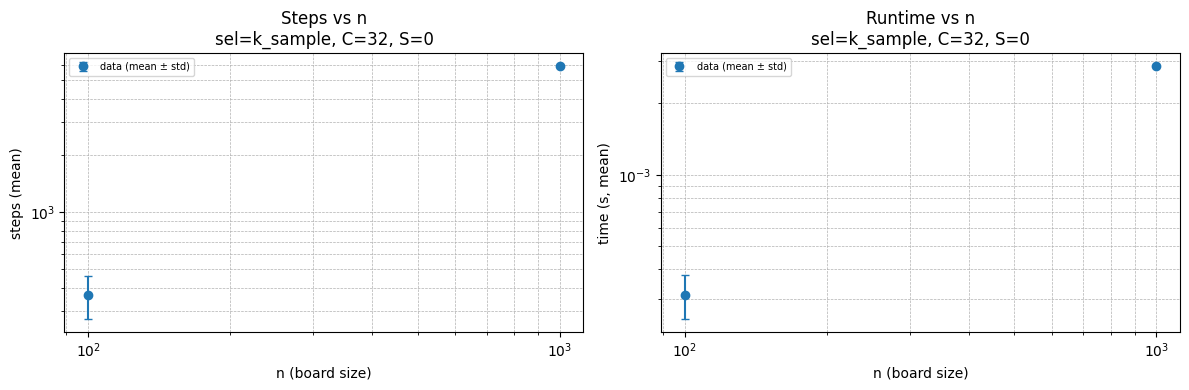

  selector=k_sample, candidate_count=32, structured_init=1


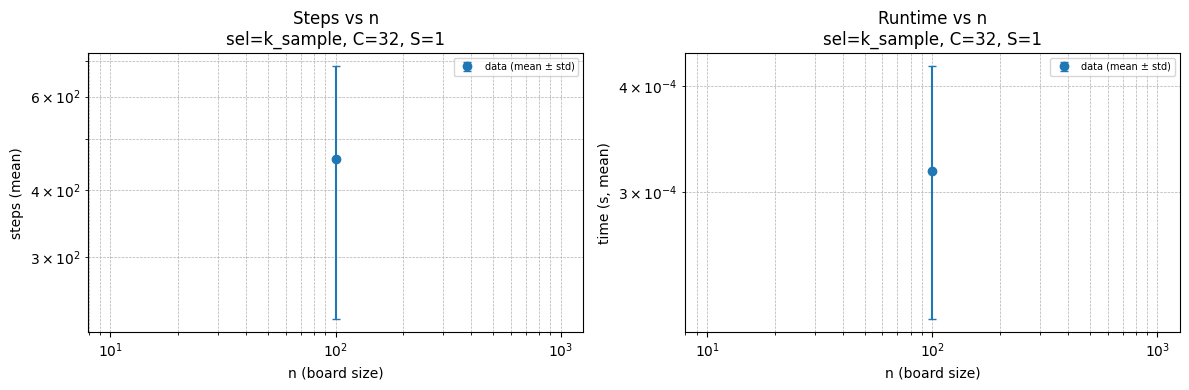

  selector=k_sample, candidate_count=128, structured_init=0


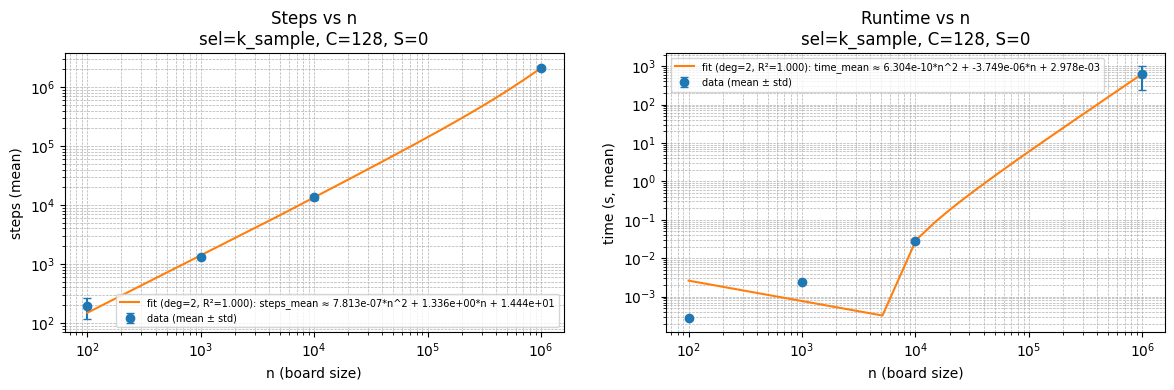

  selector=k_sample, candidate_count=128, structured_init=1


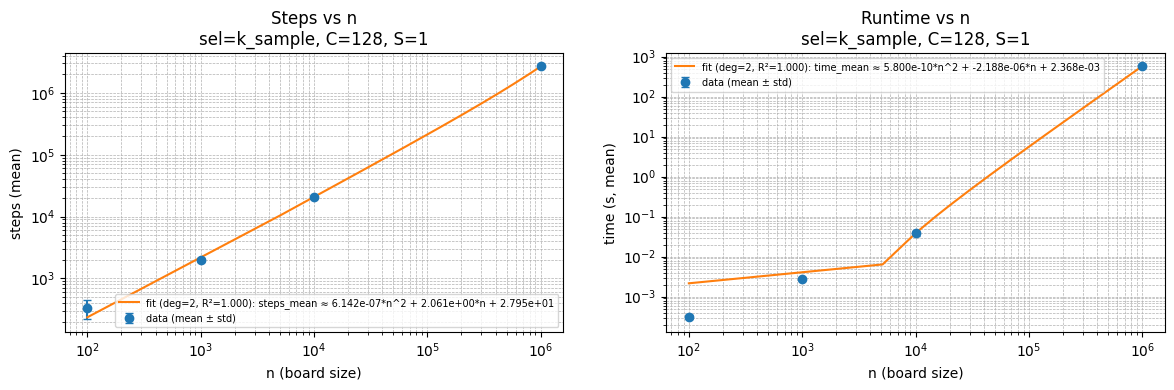

  selector=k_sample, candidate_count=512, structured_init=0


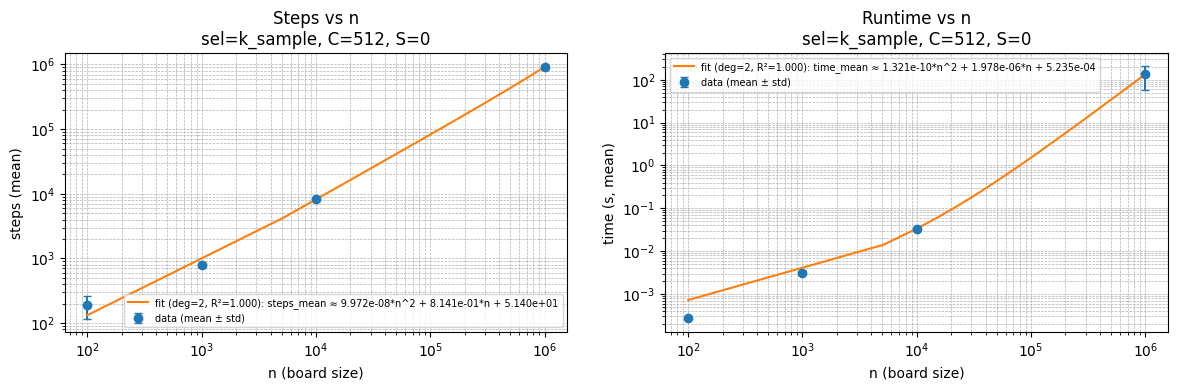

  selector=k_sample, candidate_count=512, structured_init=1


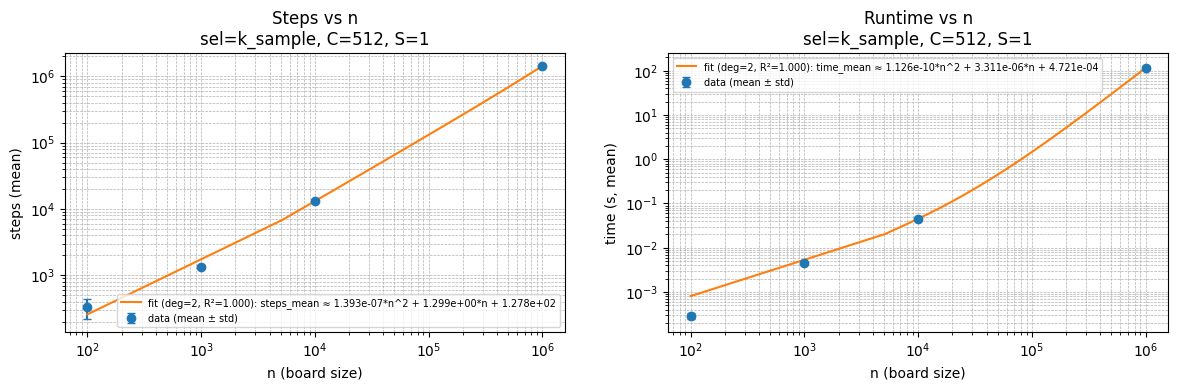

  selector=k_sample, candidate_count=1024, structured_init=0


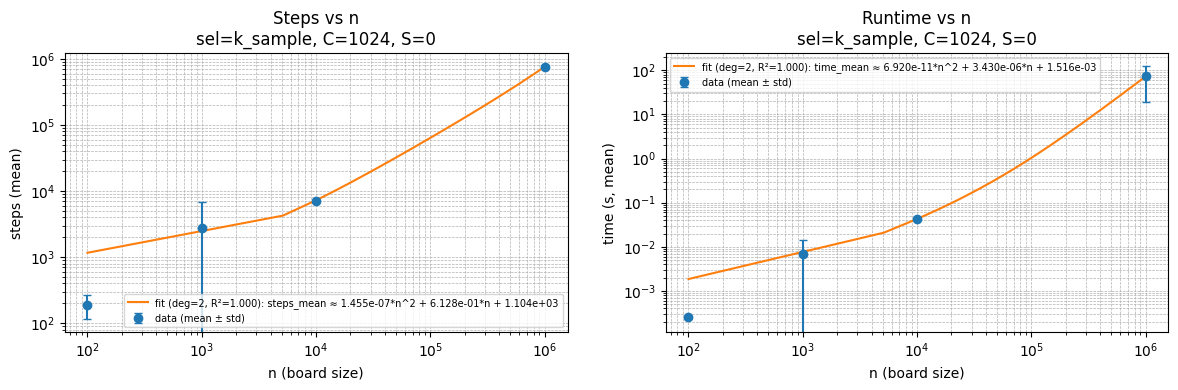

  selector=k_sample, candidate_count=1024, structured_init=1


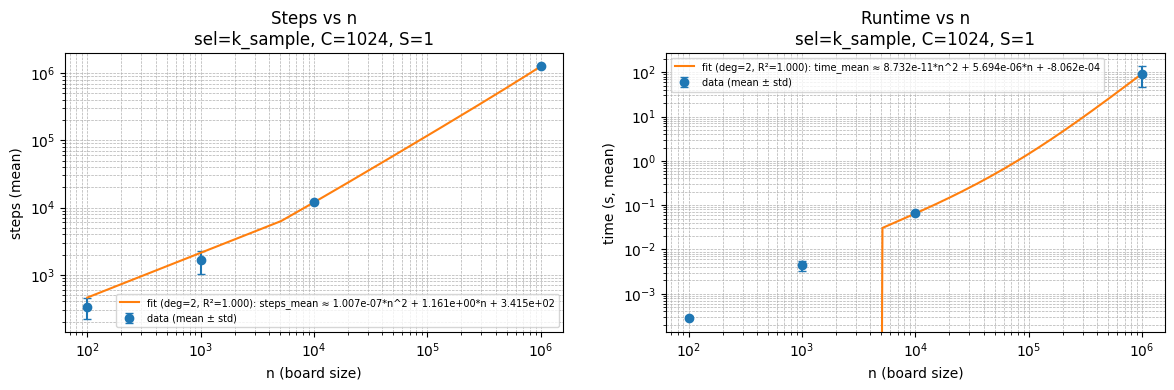

  selector=nbhd, candidate_count=32, structured_init=0


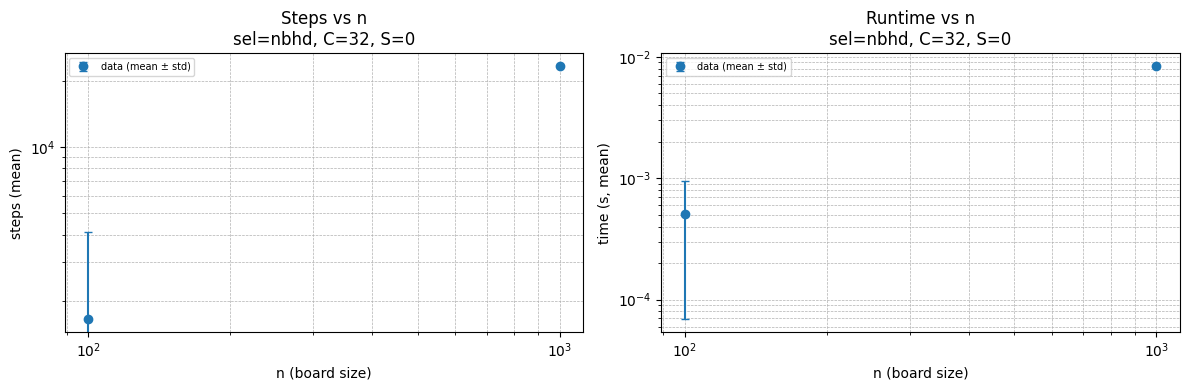

  selector=nbhd, candidate_count=32, structured_init=1


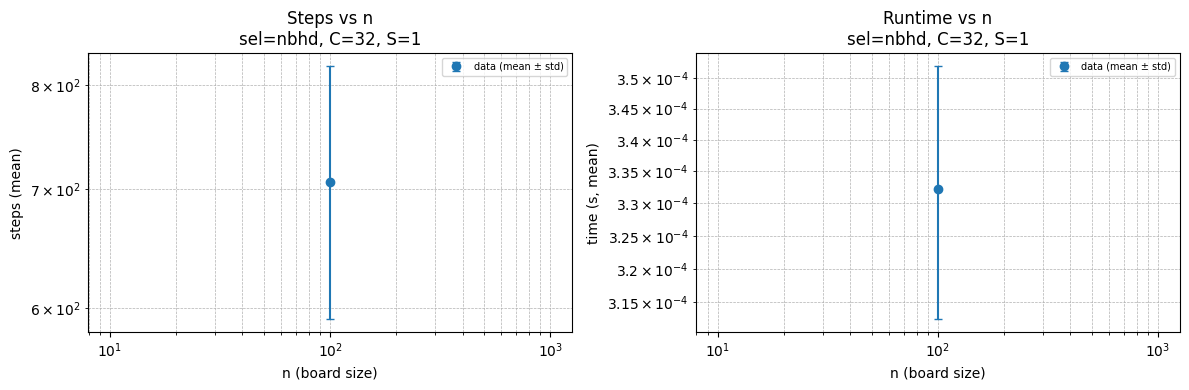

  selector=nbhd, candidate_count=128, structured_init=0


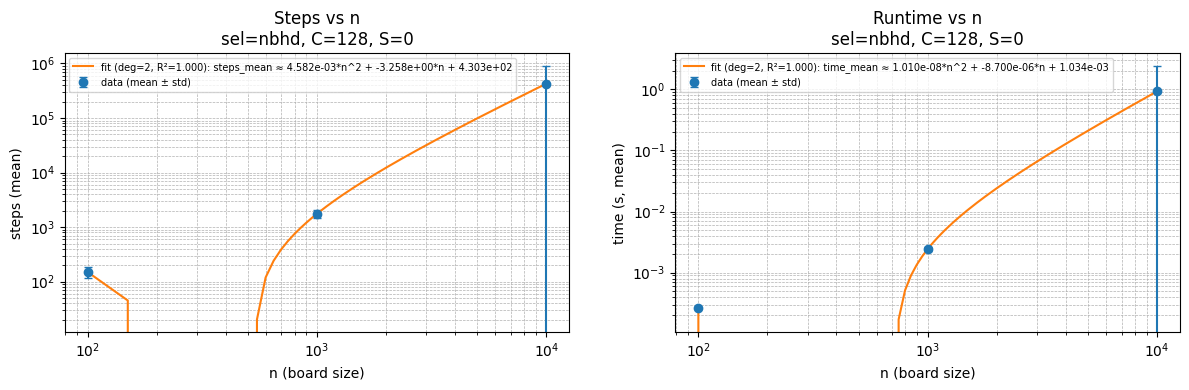

  selector=nbhd, candidate_count=128, structured_init=1


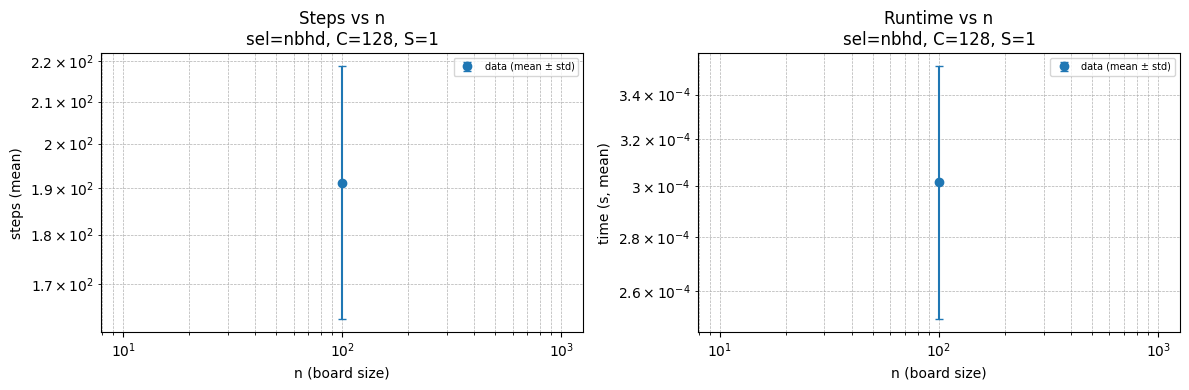

  selector=nbhd, candidate_count=512, structured_init=0


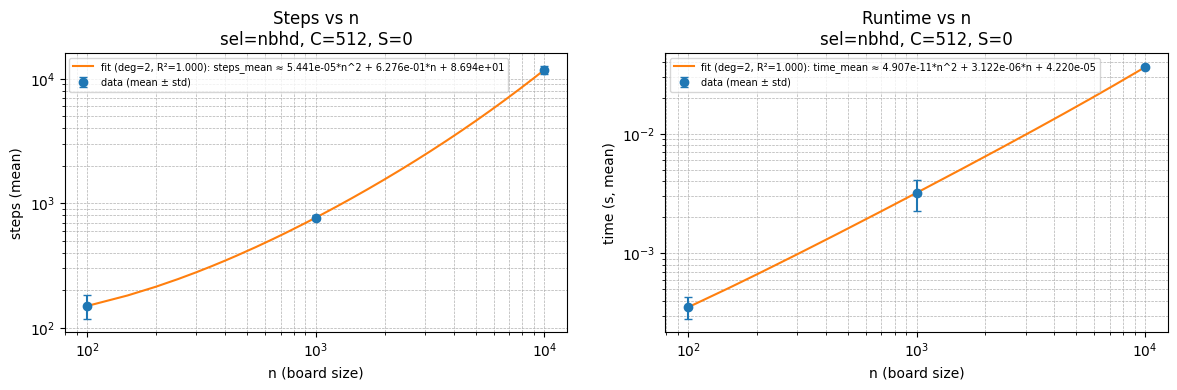

  selector=nbhd, candidate_count=512, structured_init=1


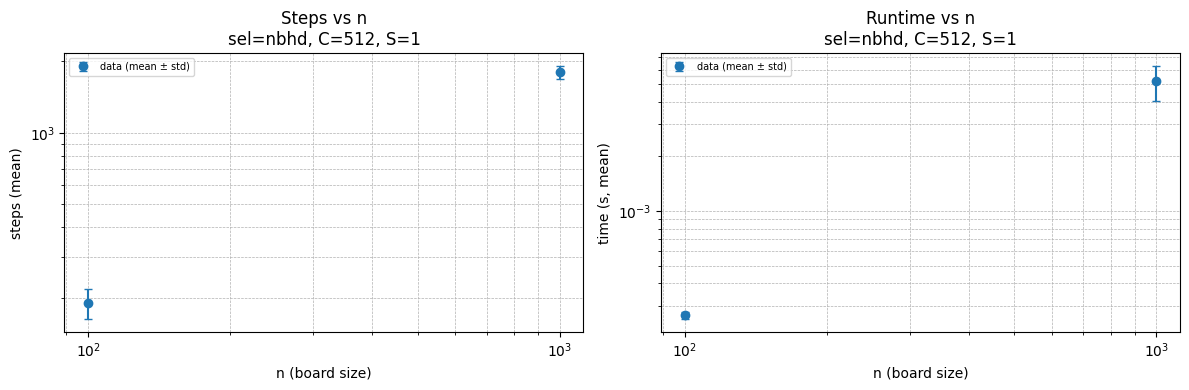

  selector=nbhd, candidate_count=1024, structured_init=0


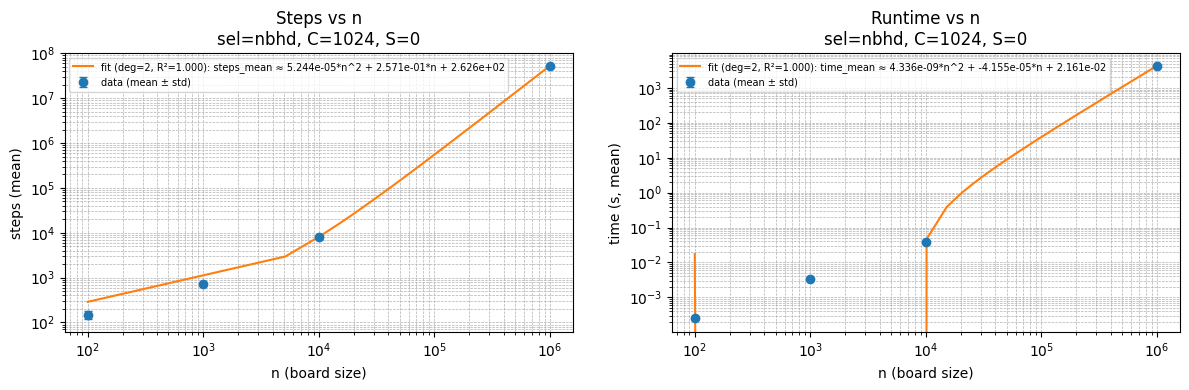

  selector=nbhd, candidate_count=1024, structured_init=1


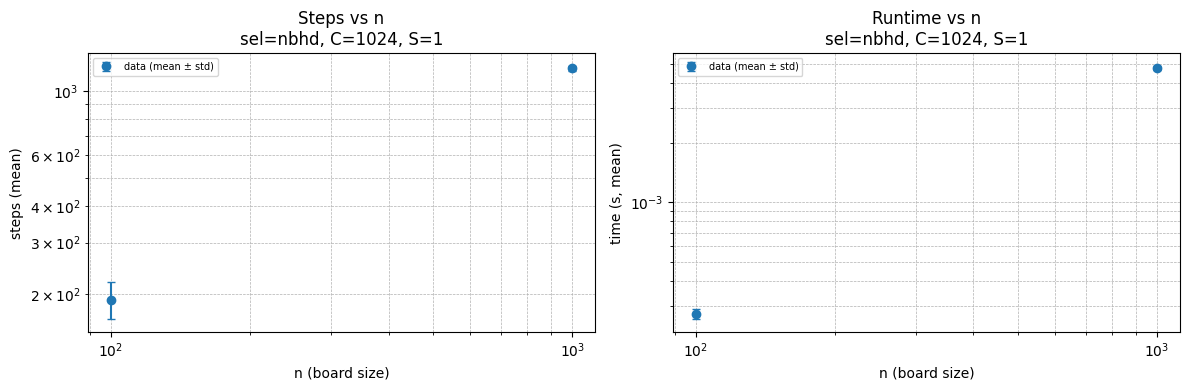

In [ ]:
# Cell 2c — scaling plots: metric vs n for each config

unique_selectors = agg["candidate_selector"].unique().tolist()
unique_counts = sorted(agg["candidate_count"].unique())
unique_structs = sorted(agg["structured_init"].unique())

print("Drawing steps/time vs n plots for all hyperparameter combos with data...")
for sel in unique_selectors:
    for c in unique_counts:
        for s in unique_structs:
            mask = (
                (agg["candidate_selector"] == sel)
                & (agg["candidate_count"] == c)
                & (agg["structured_init"] == s)
            )
            if agg[mask].empty:
                continue

            print(f"  selector={sel}, candidate_count={c}, structured_init={s}")

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            plot_metric_vs_n_with_fit(
                agg=agg,
                model_df=steps_model,
                metric_col="steps_mean",
                candidate_selector=sel,
                candidate_count=c,
                structured_init=s,
                y_label="steps (mean)",
                title=f"Steps vs n\nsel={sel}, C={c}, S={s}",
                ax=axes[0],
            )

            plot_metric_vs_n_with_fit(
                agg=agg,
                model_df=time_model,
                metric_col="time_mean",
                candidate_selector=sel,
                candidate_count=c,
                structured_init=s,
                y_label="time (s, mean)",
                title=f"Runtime vs n\nsel={sel}, C={c}, S={s}",
                ax=axes[1],
            )

            plt.tight_layout()
            plt.show()


## New Plots: Hyperparameter Effects at Fixed n

Now we flip the view:

For each **fixed board size `n`**:

- Plot **metric vs `candidate_count`**.
- Each line corresponds to a `(candidate_selector, structured_init)` combo.
- Error bars still show **std across seeds**.

We generate these plots for both:

- `steps_mean` (how many steps the solver takes), and  
- `time_mean` (runtime in seconds).


In [ ]:
# Cell 2d — hyperparameter effect plots: metric vs candidate_count at fixed n

n_values = sorted(agg["n"].unique())

for n_val in n_values:
    print(f"\n=== Hyperparameter effects at n={n_val} ===")
    plot_metric_vs_candidate_count_for_n(
        agg,
        n_value=n_val,
        metric_col="steps_mean",
        y_label="steps (mean)",
        title_prefix="Steps vs candidate_count",
    )
    plt.show()

    plot_metric_vs_candidate_count_for_n(
        agg,
        n_value=n_val,
        metric_col="time_mean",
        y_label="time (s, mean)",
        title_prefix="Runtime vs candidate_count",
    )
    plt.show()


=== Top configs minimizing predicted steps at n=1000000 ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2,n_target,pred_metric
4,k_sample,1024,0,steps_mean,2,"[1.4550656950024274e-07, 0.6128273625800108, 1...",5.271812e+05,0.999995,1000000.0,7.594375e+05
2,k_sample,512,0,steps_mean,2,"[9.971619253748032e-08, 0.8140529113748707, 51...",1.865616e+03,1.000000,1000000.0,9.138205e+05
5,k_sample,1024,1,steps_mean,2,"[1.006692589812803e-07, 1.1614504958631584, 34...",8.945694e+03,1.000000,1000000.0,1.262461e+06
3,k_sample,512,1,steps_mean,2,"[1.393383498024368e-07, 1.2986848097264672, 12...",2.963933e+03,1.000000,1000000.0,1.438151e+06
0,k_sample,128,0,steps_mean,2,"[7.812562029349852e-07, 1.335811856342989, 14....",1.013956e+03,1.000000,1000000.0,2.117083e+06
1,k_sample,128,1,steps_mean,2,"[6.142492381907491e-07, 2.0611363157775053, 27...",5.193521e+03,1.000000,1000000.0,2.675414e+06
8,nbhd,1024,0,steps_mean,2,"[5.2443203043235165e-05, 0.2570543187255271, 2...",1.067553e+04,1.000000,1000000.0,5.270052e+07
7,nbhd,512,0,steps_mean,2,"[5.441077441077458e-05, 0.6276481481481462, 86...",5.868082e-24,1.000000,1000000.0,5.503851e+07
6,nbhd,128,0,steps_mean,2,"[0.0045820089786756555, -3.2582654320988773, 4...",2.341896e-21,1.000000,1000000.0,4.578751e+09


=== Top configs minimizing predicted runtime at n=1000000 ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2,n_target,pred_metric
7,nbhd,512,0,time_mean,2,"[4.907379303459368e-11, 3.12210216482827e-06, ...",3.029739e-35,1.0,1000000.0,52.195937
4,k_sample,1024,0,time_mean,2,"[6.919935614567095e-11, 3.429541832104339e-06,...",1.437975e-06,1.0,1000000.0,72.630414
5,k_sample,1024,1,time_mean,2,"[8.732238258051726e-11, 5.694244115335985e-06,...",1.545062e-07,1.0,1000000.0,93.015821
3,k_sample,512,1,time_mean,2,"[1.1263960783871993e-10, 3.3111977623432485e-0...",1.508782e-07,1.0,1000000.0,115.951278
2,k_sample,512,0,time_mean,2,"[1.3213578992338137e-10, 1.9775244152916642e-0...",1.111775e-07,1.0,1000000.0,134.113838
1,k_sample,128,1,time_mean,2,"[5.799688935144731e-10, -2.187579762453459e-06...",1.892846e-06,1.0,1000000.0,577.783682
0,k_sample,128,0,time_mean,2,"[6.304263251611795e-10, -3.748821215023806e-06...",3.029699e-06,1.0,1000000.0,626.680482
8,nbhd,1024,0,time_mean,2,"[4.3356501823872585e-09, -4.155027447659805e-0...",1.651076e-04,1.0,1000000.0,4294.121516
6,nbhd,128,0,time_mean,2,"[1.010461475880578e-08, -8.700326235550367e-06...",4.116276e-32,1.0,1000000.0,10095.915467


## Hyperparameter Recommendation for a Target n

Using the fitted models:

- We predict `steps_mean(n_target)` and `time_mean(n_target)` for every tested hyperparameter combo.
- Then we rank configs to find the ones expected to minimize **steps** and **runtime** at that `n_target`.

Important:

> This chooses among the **discrete hyperparameter values actually present in your grid**.  
> It does *not* invent new candidate_counts, etc.; it tells you which tested configuration looks best.


In [ ]:
# Cell 2e — recommend best configs for a target n

n_target = 1_000_000  # adjust as needed

steps_pred = build_prediction_table(steps_model, n_target=n_target)
time_pred = build_prediction_table(time_model, n_target=n_target)

top_steps = recommend_configs(
    steps_pred,
    metric_col="steps_mean",
    n_target=n_target,
    top_k=10,
)
top_time = recommend_configs(
    time_pred,
    metric_col="time_mean",
    n_target=n_target,
    top_k=10,
)

print(f"=== Top configs minimizing predicted steps at n={n_target} ===")
display(top_steps)

print(f"=== Top configs minimizing predicted runtime at n={n_target} ===")
display(top_time)



=== Estimated max n for time_limit = 10.0 seconds ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2,metric_limit,max_n
7,nbhd,512,0,time_mean,2,"[4.907379303459368e-11, 3.12210216482827e-06, ...",3.029739e-35,1.0,10.0,420722.355450
4,k_sample,1024,0,time_mean,2,"[6.919935614567095e-11, 3.429541832104339e-06,...",1.437975e-06,1.0,10.0,356142.617471
5,k_sample,1024,1,time_mean,2,"[8.732238258051726e-11, 5.694244115335985e-06,...",1.545062e-07,1.0,10.0,307381.271652
3,k_sample,512,1,time_mean,2,"[1.1263960783871993e-10, 3.3111977623432485e-0...",1.508782e-07,1.0,10.0,283614.668188
2,k_sample,512,0,time_mean,2,"[1.3213578992338137e-10, 1.9775244152916642e-0...",1.111775e-07,1.0,10.0,267711.107318
1,k_sample,128,1,time_mean,2,"[5.799688935144731e-10, -2.187579762453459e-06...",1.892846e-06,1.0,10.0,133193.896708
0,k_sample,128,0,time_mean,2,"[6.304263251611795e-10, -3.748821215023806e-06...",3.029699e-06,1.0,10.0,128935.135622
8,nbhd,1024,0,time_mean,2,"[4.3356501823872585e-09, -4.155027447659805e-0...",1.651076e-04,1.0,10.0,53004.102298
6,nbhd,128,0,time_mean,2,"[1.010461475880578e-08, -8.700326235550367e-06...",4.116276e-32,1.0,10.0,31890.484095



=== Estimated max n for time_limit = 60.0 seconds ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2,metric_limit,max_n
7,nbhd,512,0,time_mean,2,"[4.907379303459368e-11, 3.12210216482827e-06, ...",3.029739e-35,1.0,60.0,1.074381e+06
4,k_sample,1024,0,time_mean,2,"[6.919935614567095e-11, 3.429541832104339e-06,...",1.437975e-06,1.0,60.0,9.066984e+05
5,k_sample,1024,1,time_mean,2,"[8.732238258051726e-11, 5.694244115335985e-06,...",1.545062e-07,1.0,60.0,7.969622e+05
3,k_sample,512,1,time_mean,2,"[1.1263960783871993e-10, 3.3111977623432485e-0...",1.508782e-07,1.0,60.0,7.152910e+05
2,k_sample,512,0,time_mean,2,"[1.3213578992338137e-10, 1.9775244152916642e-0...",1.111775e-07,1.0,60.0,6.664090e+05
1,k_sample,128,1,time_mean,2,"[5.799688935144731e-10, -2.187579762453459e-06...",1.892846e-06,1.0,60.0,3.235275e+05
0,k_sample,128,0,time_mean,2,"[6.304263251611795e-10, -3.748821215023806e-06...",3.029699e-06,1.0,60.0,3.114822e+05
8,nbhd,1024,0,time_mean,2,"[4.3356501823872585e-09, -4.155027447659805e-0...",1.651076e-04,1.0,60.0,1.225063e+05
6,nbhd,128,0,time_mean,2,"[1.010461475880578e-08, -8.700326235550367e-06...",4.116276e-32,1.0,60.0,7.748870e+04



=== Estimated max n for time_limit = 300.0 seconds ===


,candidate_selector,candidate_count,structured_init,metric_col,chosen_degree,coeffs,mse,r2,metric_limit,max_n
7,nbhd,512,0,time_mean,2,"[4.907379303459368e-11, 3.12210216482827e-06, ...",3.029739e-35,1.0,300.0,2.440891e+06
4,k_sample,1024,0,time_mean,2,"[6.919935614567095e-11, 3.429541832104339e-06,...",1.437975e-06,1.0,300.0,2.057500e+06
5,k_sample,1024,1,time_mean,2,"[8.732238258051726e-11, 5.694244115335985e-06,...",1.545062e-07,1.0,300.0,1.821207e+06
3,k_sample,512,1,time_mean,2,"[1.1263960783871993e-10, 3.3111977623432485e-0...",1.508782e-07,1.0,300.0,1.617348e+06
2,k_sample,512,0,time_mean,2,"[1.3213578992338137e-10, 1.9775244152916642e-0...",1.111775e-07,1.0,300.0,1.499316e+06
1,k_sample,128,1,time_mean,2,"[5.799688935144731e-10, -2.187579762453459e-06...",1.892846e-06,1.0,300.0,7.210998e+05
0,k_sample,128,0,time_mean,2,"[6.304263251611795e-10, -3.748821215023806e-06...",3.029699e-06,1.0,300.0,6.928084e+05
8,nbhd,1024,0,time_mean,2,"[4.3356501823872585e-09, -4.155027447659805e-0...",1.651076e-04,1.0,300.0,2.678730e+05
6,nbhd,128,0,time_mean,2,"[1.010461475880578e-08, -8.700326235550367e-06...",4.116276e-32,1.0,300.0,1.727369e+05


## Estimating Maximum n for a Given Time Budget

Finally, we invert the time models:

For each hyperparameter combo:

1. Take the fitted polynomial model `time_mean(n)`.
2. For a given time limit `T` (in seconds), solve `time_mean(n) = T`.
3. Keep the largest positive real root as `max_n`.

This gives an estimate of the largest board size solvable within that time budget for each config.


In [ ]:
# Cell 2f — estimate max n for a set of time limits

time_limits = [10.0, 60.0, 300.0]  # 10s, 1min, 5min

for T in time_limits:
    print(f"\n=== Estimated max n for time_limit = {T} seconds ===")
    maxn_time = compute_max_n_for_metric_limit(
        model_df=time_model,
        metric_col="time_mean",
        metric_limit=T,
    )
    maxn_sorted = maxn_time.sort_values("max_n", ascending=False)
    display(maxn_sorted.head(10))

# If you also want to estimate max n for a step budget, you can do:
# step_budget = 5e7
# maxn_steps = compute_max_n_for_metric_limit(
#     model_df=steps_model,
#     metric_col="steps_mean",
#     metric_limit=step_budget,
# )
# display(maxn_steps.sort_values("max_n", ascending=False).head(10))
